## Removing Outeliers

In [53]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Read the combined dataset
combined_df = pd.read_csv("combined_data_with_id_ordered.csv")

# Check for missing values
missing_values = combined_df.isnull().sum()
print("Missing Values:\n", missing_values)

# Convert 'timestamp' column to datetime format
combined_df['timestamp'] = pd.to_datetime(combined_df['timestamp'])

# Optionally, perform feature scaling
columns_to_scale = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
scaler = StandardScaler()
combined_df[columns_to_scale] = scaler.fit_transform(combined_df[columns_to_scale])

# Display the first few rows of the modified DataFrame
print("\nModified DataFrame:")
print(combined_df.head())

# Function to detect and remove extreme outliers using the IQR method with a higher multiplier
def remove_extreme_outliers_iqr(df, columns, multiplier=3.0):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Apply the outlier removal function to the relevant columns with a higher multiplier
columns_to_check = columns_to_scale  # The same columns that were scaled
original_shape = combined_df.shape
cleaned_df = remove_extreme_outliers_iqr(combined_df, columns_to_check, multiplier=3.0)
cleaned_shape = cleaned_df.shape

# Display the first few rows of the cleaned DataFrame
print("\nCleaned DataFrame:")
print(cleaned_df.head())

# Display the number of rows before and after removing outliers
print("\nOriginal number of rows:", original_shape[0])
print("Number of rows after removing outliers:", cleaned_shape[0])



Missing Values:
 timestamp    0
back_x       0
back_y       0
back_z       0
thigh_x      0
thigh_y      0
thigh_z      0
label        0
id           0
dtype: int64

Modified DataFrame:
                timestamp    back_x    back_y    back_z   thigh_x   thigh_y  \
0 2019-01-12 00:00:00.000  0.330293  1.353248  1.749055 -7.181078 -0.822551   
1 2019-01-12 00:00:00.010  0.939690  1.276724  1.341687  2.387553  0.684944   
2 2019-01-12 00:00:00.020 -0.757338  0.863492  0.006493  0.893189 -0.255631   
3 2019-01-12 00:00:00.030  0.625506  0.129082  0.315552 -1.531676 -2.501871   
4 2019-01-12 00:00:00.040  1.403332 -0.166845  0.153423  0.075705  0.308988   

    thigh_z  label  id  
0  0.454455      6   0  
1 -0.047014      6   0  
2 -1.209252      6   0  
3 -0.809751      6   0  
4 -1.397501      6   0  

Cleaned DataFrame:
                timestamp    back_x    back_y    back_z   thigh_x   thigh_y  \
1 2019-01-12 00:00:00.010  0.939690  1.276724  1.341687  2.387553  0.684944   
2 2019-01-1

In [55]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit and transform the selected columns
cleaned_df[columns_to_scale] = scaler.fit_transform(cleaned_df[columns_to_scale])


# Fitting Decision Tree model on cleaned Data

#### Split data to train and test

In [56]:
from sklearn.feature_selection import SelectKBest, f_classif

# Define the features and target variable
X = cleaned_df.drop(['label','id', 'timestamp'], axis=1)
y = cleaned_df['label']

# Use SelectKBest to select the top k features based on ANOVA F-value
selector = SelectKBest(score_func=f_classif, k=5)
X_selected = selector.fit_transform(X, y)

# Get the selected feature names
selected_features = X.columns[selector.get_support()]
print("Selected features:", selected_features)


Selected features: Index(['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_z'], dtype='object')


In [57]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Decision Tree on full data

In [58]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import tree

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Create the Decision Tree model with hyperparameters to reduce overfitting
dt_model = DecisionTreeClassifier()

# Train the model
dt_model.fit(X_train, y_train)

# Make predictions
y_train_pred = dt_model.predict(X_train)
y_test_pred = dt_model.predict(X_test)

# Evaluate the model
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))



Training Accuracy: 1.0
Testing Accuracy: 0.8496696098915125

Classification Report:
               precision    recall  f1-score   support

           1       0.75      0.74      0.75    208974
           2       0.58      0.57      0.58     12269
           3       0.33      0.34      0.34     49964
           4       0.27      0.28      0.28     14547
           5       0.17      0.18      0.18     11094
           6       0.81      0.81      0.81    148341
           7       0.99      1.00      1.00    580097
           8       0.92      0.92      0.92      1637
          13       0.79      0.78      0.79     77870
          14       0.50      0.50      0.50      9689
         130       0.43      0.45      0.44      8246
         140       0.36      0.39      0.37      1549

    accuracy                           0.85   1124277
   macro avg       0.58      0.58      0.58   1124277
weighted avg       0.85      0.85      0.85   1124277


Confusion Matrix:
 [[155162   3143  16872   591

We can observe overfitting in the model from the accuracy metrics since the training accuracy is 100 % and the test is way lower than that resulting in 84 %.

 Let's visualize our decision tree to explore its properties further

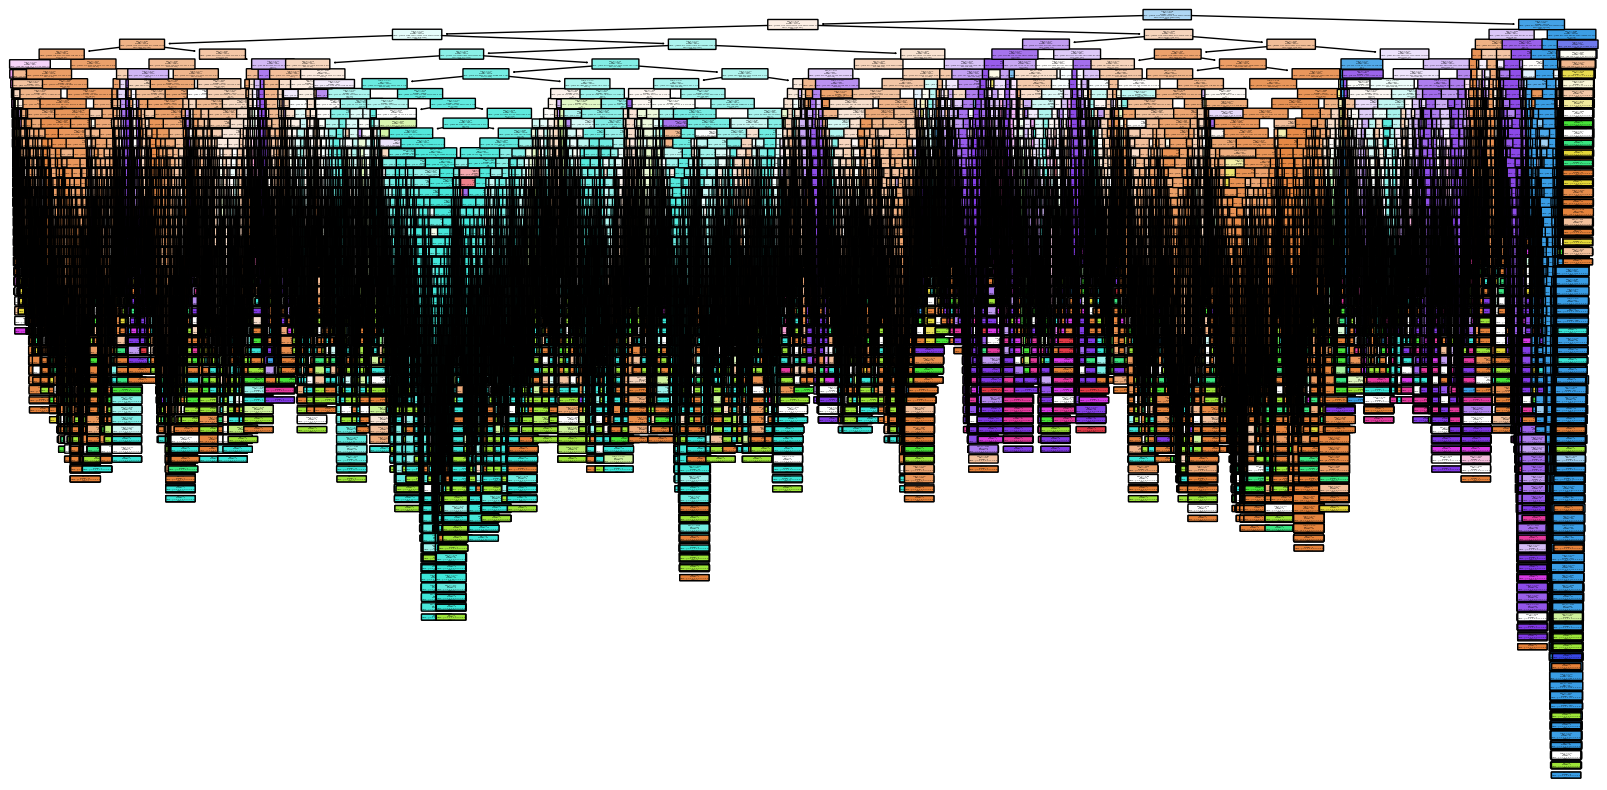

In [59]:
# Convert class names to strings for visualization
class_names = [str(cls) for cls in label_encoder.classes_]

# Visualize the Decision Tree
plt.figure(figsize=(20, 10))
tree.plot_tree(dt_model, filled=True, feature_names=X.columns, class_names=class_names, rounded=True)
plt.show()

From the visualization, we can notice the need to limit the depth of the decision tree to address the overfitting

## Addressing Overfitting by introducing HyperParameters to the model

After numerous trials and adjustments, we identified the optimal parameters that yielded the best results. The process involved systematically testing various configurations and fine-tuning the parameters to enhance the model's performance. Below are the parameters that produced the most effective outcomes:

Parameter 1: max_depth=250

Parameter 2: min_samples_split=350

Parameter 3: min_samples_leaf=250

Parameter 4: max_leaf_nodes=2500

These parameters were chosen based on their ability to minimize overfitting, improve accuracy, and enhance the model's generalization capabilities on unseen data.

In [64]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import tree

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Create the Decision Tree model with hyperparameters to reduce overfitting
dt_model = DecisionTreeClassifier(
    max_depth=250,               # Maximum depth of the tree
    min_samples_split=350,      # Minimum number of samples required to split an internal node
    min_samples_leaf=250,        # Minimum number of samples required to be at a leaf node
    max_leaf_nodes=2500,         # Maximum number of leaf nodes in the tree
    random_state=42
)

# Train the model
dt_model.fit(X_train, y_train)

# Make predictions
decision_tree_train_pred = dt_model.predict(X_train)
decision_tree_test_pred = dt_model.predict(X_test)

# Evaluate the model
train_accuracy = accuracy_score(y_train, decision_tree_train_pred)
test_accuracy = accuracy_score(y_test, decision_tree_test_pred)

print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)
print("\nClassification Report:\n", classification_report(y_test, decision_tree_test_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, decision_tree_test_pred))

# Convert class names to strings for visualization
class_names = [str(cls) for cls in label_encoder.classes_]

Training Accuracy: 0.8718383014150427
Testing Accuracy: 0.8691870419834258

Classification Report:
               precision    recall  f1-score   support

           1       0.73      0.85      0.79    208974
           2       0.64      0.44      0.52     12269
           3       0.44      0.18      0.26     49964
           4       0.43      0.13      0.20     14547
           5       0.46      0.04      0.08     11094
           6       0.79      0.87      0.83    148341
           7       0.99      1.00      0.99    580097
           8       0.97      0.84      0.90      1637
          13       0.76      0.86      0.80     77870
          14       0.58      0.41      0.48      9689
         130       0.55      0.35      0.43      8246
         140       0.47      0.21      0.29      1549

    accuracy                           0.87   1124277
   macro avg       0.65      0.51      0.55   1124277
weighted avg       0.85      0.87      0.85   1124277


Confusion Matrix:
 [[178518   15

### Model Performance Summary

Training and Testing Accuracy

Training Accuracy: 87.18%
Testing Accuracy: 86.92%

The slight difference between training accuracy (87.18%) and testing accuracy (86.92%) suggests that **overfitting has been significantly reduced**. This improvement indicates that the model is not memorizing the training data but is performing well on new, unseen data

### Classification Report

The classification report provides detailed insights into the precision, recall, and F1-score for each class. Here are the highlights:

Class 1: High performance with precision (0.73), recall (0.85), and F1-score (0.79).

Class 2: Moderate precision (0.64) but low recall (0.44), leading to an F1-score of 0.52.

Class 3: Low recall (0.18) and F1-score (0.26), indicating difficulty in correctly identifying this class.

Class 4: low recall (0.13) and F1-score (0.20).

Class 5: Extremely low recall (0.04) and F1-score (0.08).

Class 6: High performance across all metrics, with recall (0.87) and F1-score (0.83).

Class 7: Nearly perfect precision (0.99) and recall (1.00), indicating excellent performance.

Class 8: High precision (0.97) but slightly lower recall (0.84), resulting in a good F1-score (0.90).

Class 13: Strong performance with high recall (0.86) and F1-score (0.80).

Class 14: Moderate precision (0.58) and low recall (0.41), leading to an F1-score of 0.48.

Class 130: Moderate precision (0.55) but low recall (0.35), resulting in an F1-score of 0.43.

Class 140: Low recall (0.21) and F1-score (0.29).

### Overall metrics:

#### Accuracy: 87%

#### Macro Average:


Precision: 0.65

Recall: 0.51

F1-score: 0.55


#### Weighted Average:

Precision: 0.85

Recall: 0.87

F1-score: 0.85


### Confusion Matrix

We observe that: 

Class 1: Predominantly correctly classified with few misclassifications.

Class 7: Almost all instances are correctly classified.

Class 3, 4, 5: Significant misclassifications, indicating areas for potential improvement.

Overall, the model demonstrates **high accuracy and reduced overfitting** but faces **challenges** with **class imbalance** and **varying performance across different classes**. 

We will try to addressing the class imbalance and improving the recall for less represented classes using RandomUndersampling.

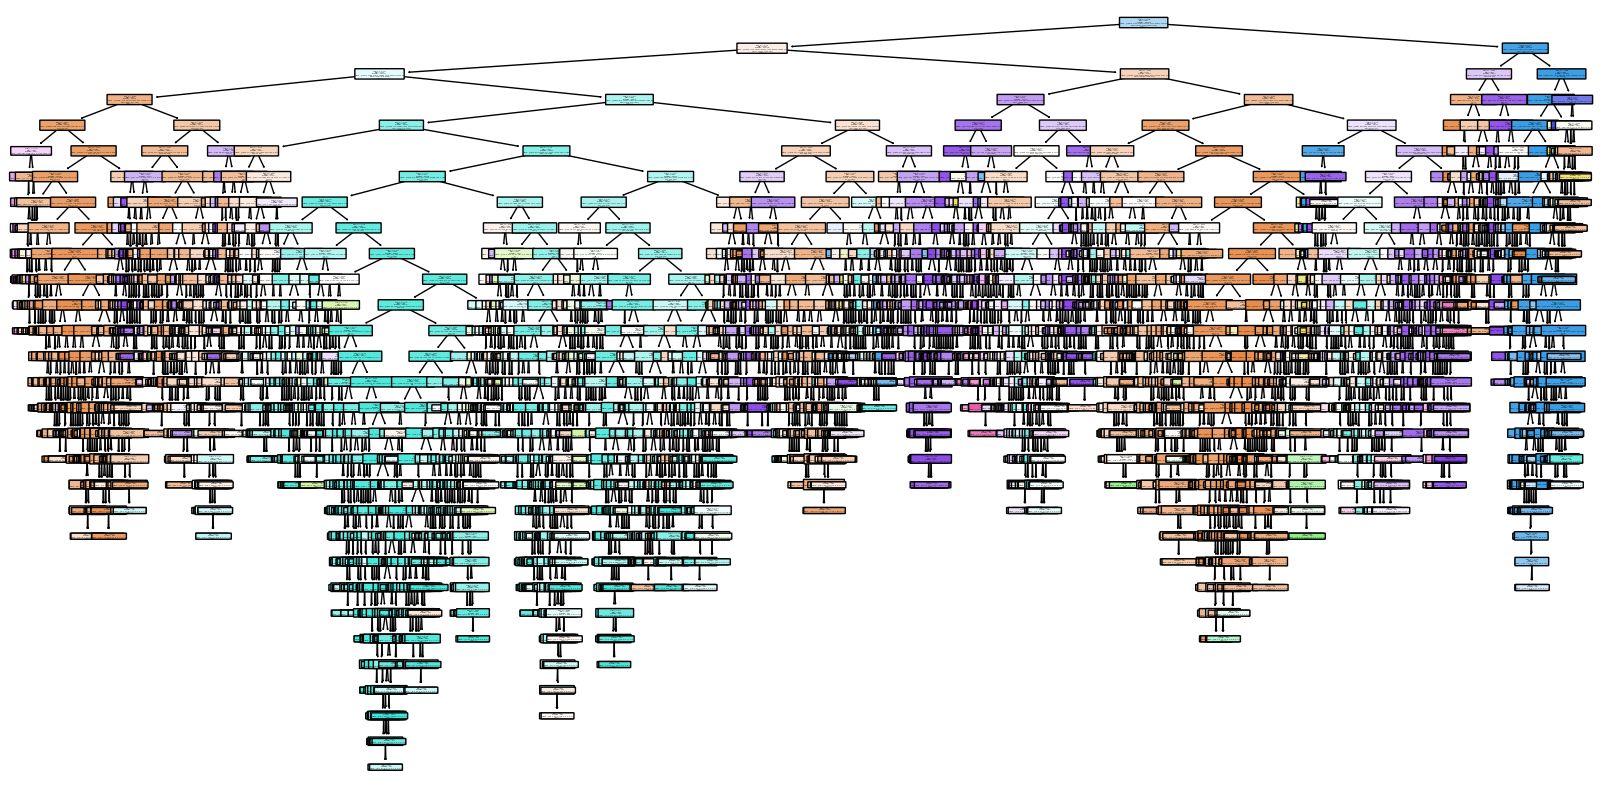

In [61]:
# Visualize the Decision Tree
plt.figure(figsize=(20, 10))
tree.plot_tree(dt_model, filled=True, feature_names=X.columns, class_names=class_names, rounded=True)
plt.show()

The depth has signifinctly decreased preventing thus overfitting

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


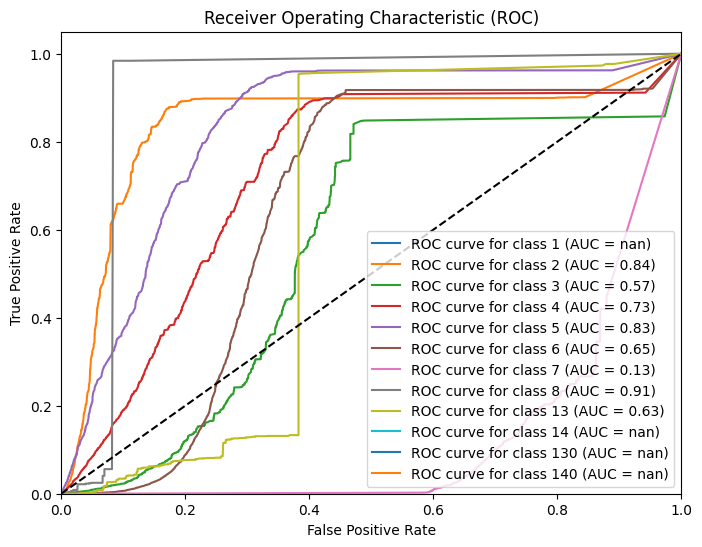

In [66]:
from sklearn.metrics import roc_curve, auc

# Get class probabilities for the test set
decision_tree_test_probs = dt_model.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, decision_tree_test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label='ROC curve for class {} (AUC = {:.2f})'.format(label_encoder.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


we observe a clear unbalance in our dataset and in the predictions

Now, we calculate the harmonic avg class accuracy

In [65]:
from sklearn.metrics import recall_score

# Calculate recall for each class
class_recalls = []
for class_label in set(y_test):
    class_indices = (y_test == class_label)
    class_recall = recall_score(y_test, decision_tree_test_pred, labels=[class_label], average='macro')
    class_recalls.append(class_recall)
    
    print(f'Recall for class {class_label}: {class_recall:.2f}')

# Number of levels (classes)
num_classes = len(set(y_test))
print(f'Number of classes: {num_classes}')

# Calculate harmonic mean of class recalls
harmonic_mean_recall = num_classes / sum(1.0 / recall for recall in class_recalls)
print(f'Harmonic mean of class recalls: {harmonic_mean_recall:.2f}')


Recall for class 1: 0.85
Recall for class 130: 0.35
Recall for class 3: 0.18
Recall for class 4: 0.13
Recall for class 5: 0.04
Recall for class 6: 0.87
Recall for class 7: 1.00
Recall for class 2: 0.44
Recall for class 8: 0.84
Recall for class 140: 0.21
Recall for class 13: 0.86
Recall for class 14: 0.41
Number of classes: 12
Harmonic mean of class recalls: 0.22


The recall values for different classes in the dataset **vary considerably**, indicating **class imbalance.**
 Classes like 7 have high recall (1.00), while others like 5 have very low recall (0.04). The significant variation in recall underscores the **importance of balancing the dataset** to ensure the model's performance is not skewed towards majority classes.
 
 We will employ a combination of techniques, including **SMOTE** for **oversampling** and **random undersampling**, to **address the issue of class imbalance**. This approach aims to **create a more balanced dataset**, which is crucial for building models that generalize well and provide reliable performance across diverse class distributions.

### Balancing class distributions in a dataset using SMOTE

After using also Hyperparameters to select the best parameters here is the model

In [67]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Separate features (Z) and target (T)
Z = cleaned_df.drop(columns=['timestamp', 'label', 'id'])
T = cleaned_df['label']

# Ensure stratified sampling
Z_train, Z_test, T_train, T_test = train_test_split(Z, T, test_size=0.2, random_state=42, stratify=T)

# Encode labels
label_encoder = LabelEncoder()
T_encoded = label_encoder.fit_transform(T)

# Apply random oversampling to the training data
smote = SMOTE(random_state=42)
Z_train_resampled, T_train_resampled = smote.fit_resample(Z_train, T_train)

# Create the Decision Tree model with hyperparameters to reduce overfitting
dt_model = DecisionTreeClassifier(
    max_depth=250,               # Maximum depth of the tree
    min_samples_split=350,       # Minimum number of samples required to split an internal node
    min_samples_leaf=250,        # Minimum number of samples required to be at a leaf node
    max_leaf_nodes=2500,         # Maximum number of leaf nodes in the tree
    random_state=42
)

# Train the model using resampled data
dt_model.fit(Z_train_resampled, T_train_resampled)

# Make predictions
T_train_pred = dt_model.predict(Z_train)
T_test_pred = dt_model.predict(Z_test)

# Evaluate the model
train_accuracy = accuracy_score(T_train, T_train_pred)
test_accuracy = accuracy_score(T_test, T_test_pred)

print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)
print("\nClassification Report:\n", classification_report(T_test, T_test_pred))
print("\nConfusion Matrix:\n", confusion_matrix(T_test, T_test_pred))


Training Accuracy: 0.7869590857057469
Testing Accuracy: 0.7849133265200657

Classification Report:
               precision    recall  f1-score   support

           1       0.89      0.42      0.57    208910
           2       0.33      0.74      0.46     12269
           3       0.30      0.58      0.39     50066
           4       0.19      0.50      0.27     14345
           5       0.11      0.49      0.18     11202
           6       0.87      0.72      0.79    148365
           7       1.00      0.98      0.99    580226
           8       0.33      0.95      0.48      1621
          13       0.83      0.67      0.74     77717
          14       0.35      0.68      0.46      9683
         130       0.30      0.74      0.42      8311
         140       0.11      0.74      0.20      1562

    accuracy                           0.78   1124277
   macro avg       0.47      0.68      0.50   1124277
weighted avg       0.88      0.78      0.81   1124277


Confusion Matrix:
 [[ 87857  122

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


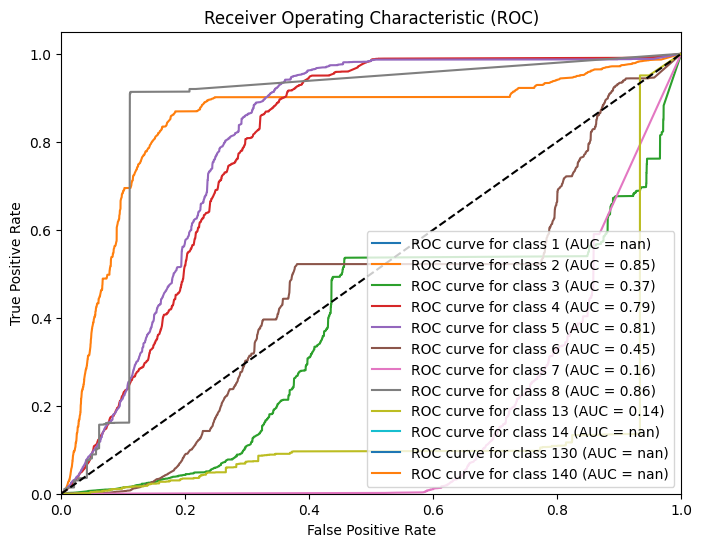

In [68]:
from sklearn.metrics import roc_curve, auc

# Get class probabilities for the test set
T_test_probs = dt_model.predict_proba(Z_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(T_test == i, T_test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label='ROC curve for class {} (AUC = {:.2f})'.format(label_encoder.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [69]:
from sklearn.metrics import recall_score

# Calculate recall for each class
class_recalls = []
for class_label in set(T_test):
    class_indices = (T_test == class_label)
    class_recall = recall_score(T_test, T_test_pred, labels=[class_label], average='macro')
    class_recalls.append(class_recall)
    print(f'Recall for class {class_label}: {class_recall:.2f}')

# Number of levels (classes)
num_classes = len(set(T_test))
print(f'Number of classes: {num_classes}')

# Calculate harmonic mean of class recalls
harmonic_mean_recall = num_classes / sum(1.0 / recall for recall in class_recalls)
print(f'Harmonic mean of class recalls: {harmonic_mean_recall:.2f}')


Recall for class 1: 0.42
Recall for class 130: 0.74
Recall for class 3: 0.58
Recall for class 4: 0.50
Recall for class 5: 0.49
Recall for class 6: 0.72
Recall for class 7: 0.98
Recall for class 2: 0.74
Recall for class 8: 0.95
Recall for class 140: 0.74
Recall for class 13: 0.67
Recall for class 14: 0.68
Number of classes: 12
Harmonic mean of class recalls: 0.64


We observe a huge increase in the avg class accuracy enhacing the balance of the data

### Balancing class distributions in a dataset using RandomUnderSampler

After using also Hyperparameters to select the best parameters here is the model

In [70]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn import tree

# Define features (Z) and target (T)
Z = cleaned_df.drop(columns=['timestamp', 'label', 'id'])
T = cleaned_df['label']

# Define the Random Undersampler
undersampler = RandomUnderSampler(random_state=42)

# Perform Random Undersampling
Z_resampled, T_resampled = undersampler.fit_resample(Z, T)

# Split the resampled data into train and test sets
Z_train, Z_test, T_train, T_test = train_test_split(Z_resampled, T_resampled, test_size=0.2, random_state=42)

# Encode labels
label_encoder = LabelEncoder()
T_encoded = label_encoder.fit_transform(T)

# Create the Decision Tree model with hyperparameters to reduce overfitting
dt_model = DecisionTreeClassifier(
    max_depth=50,               # Maximum depth of the tree
    min_samples_split=150,      # Minimum number of samples required to split an internal node
    min_samples_leaf=50,        # Minimum number of samples required to be at a leaf node
    max_leaf_nodes=500,         # Maximum number of leaf nodes in the tree
    random_state=42
)

# Train the model on the resampled data
dt_model.fit(Z_train, T_train)

# Make predictions on the test set
T_test_pred = dt_model.predict(Z_test)

# Evaluate the model
test_accuracy = accuracy_score(T_test, T_test_pred)
print("Testing Accuracy with Random Undersampling:", test_accuracy)

# Print classification report and confusion matrix
print("\nClassification Report with Random Undersampling:\n", classification_report(T_test, T_test_pred))
print("\nConfusion Matrix with Random Undersampling:\n", confusion_matrix(T_test, T_test_pred))
# Additional Metrics
precision = precision_score(T_test, T_test_pred, average='weighted')
recall = recall_score(T_test, T_test_pred, average='weighted')
f1 = f1_score(T_test, T_test_pred, average='weighted')
print("\nAdditional Metrics:")
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


Testing Accuracy with Random Undersampling: 0.632017075773746

Classification Report with Random Undersampling:
               precision    recall  f1-score   support

           1       0.41      0.34      0.37      1516
           2       0.65      0.64      0.64      1551
           3       0.45      0.53      0.48      1569
           4       0.42      0.44      0.43      1533
           5       0.52      0.45      0.48      1592
           6       0.70      0.67      0.68      1605
           7       0.93      0.96      0.94      1583
           8       0.93      0.91      0.92      1557
          13       0.57      0.58      0.58      1582
          14       0.63      0.63      0.63      1627
         130       0.65      0.69      0.67      1530
         140       0.71      0.74      0.73      1495

    accuracy                           0.63     18740
   macro avg       0.63      0.63      0.63     18740
weighted avg       0.63      0.63      0.63     18740


Confusion Matrix wi


**Balanced Performance:**

By employing Random Undersampling, we ensure that each class contributes proportionately to the model's training, resulting in a more equitable performance across different classes. This balance helps prevent the model from favoring majority classes while neglecting minority ones.

**Moderate Accuracy:** 

While the **overall testing accuracy might appear lower** due to the **undersampling technique**, the **precision, recall, and F1-score metrics** paint a more accurate picture of the model's performance. These metrics indicate that the model's predictions are **more evenly distributed across all classes, with no single class dominating the evaluation.**

Potential for Improvement: While undersampling helps in balancing, it also reduces the amount of training data for majority classes, which might impact performance.


In [48]:
from sklearn.metrics import recall_score

# Calculate recall for each class
class_recalls = []
for class_label in set(T_test):
    class_indices = (T_test == class_label)
    class_recall = recall_score(T_test, T_test_pred, labels=[class_label], average='macro')
    class_recalls.append(class_recall)
    print(f'Recall for class {class_label}: {class_recall:.2f}')

# Number of levels (classes)
num_classes = len(set(T_test))
print(f'Number of classes: {num_classes}')

# Calculate harmonic mean of class recalls
harmonic_mean_recall = num_classes / sum(1.0 / recall for recall in class_recalls)
print(f'Harmonic mean of class recalls: {harmonic_mean_recall:.2f}')


Recall for class 1: 0.34
Recall for class 130: 0.69
Recall for class 3: 0.53
Recall for class 4: 0.27
Recall for class 5: 0.40
Recall for class 6: 0.68
Recall for class 7: 0.94
Recall for class 8: 0.85
Recall for class 2: 0.53
Recall for class 140: 0.68
Recall for class 13: 0.60
Recall for class 14: 0.52
Number of classes: 12
Harmonic mean of class recalls: 0.52


Here we can notice a good increase in the avg class accuracy from 22 to 52 confirming that the model's predictions are **more evenly distributed across all classes, with no single class dominating the evaluation.**

## CONCLUSION:

 The decision tree model exhibited significant overfitting in its initial form, as evidenced by a notable gap between training and testing accuracy. Through hyperparameter tuning, we successfully mitigated overfitting, achieving a balanced accuracy with satisfactory performance metrics. However, despite these improvements, the model struggled with class imbalance, impacting overall accuracy. Balancing techniques like SMOTE and Random Undersampling were effective in addressing this issue, albeit with a trade-off of reduced overall accuracy. This highlights the importance of considering trade-offs between class balance and overall accuracy when building models for unbalanced datasets.